In [2]:
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))


In [5]:
# !pip install scikit-learn sentence-transformers matplotlib seaborn joblib
from pathlib import Path
import re, os, joblib, numpy as np, pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt; import seaborn as sns
from sentence_transformers import SentenceTransformer
from app.ml.text_preprocessor import TextPreprocessor
from app.ml.embedding_vectorizer import EmbeddingVectorizer


In [6]:
# load dataset 
DATA_PATH = Path("dataset.csv")
df = pd.read_csv(DATA_PATH)

# shuffle
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
print(df.head())

# Label distribution
label_counts = df["intent"].value_counts()
display(label_counts)


#split dataset 
X = df["text"]
y = df["intent"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Train: {len(X_train)}, Test: {len(X_test)}")

                                             text              intent
0       what criteria must be met before merging?  code_review_policy
1      can i get onboarding instructions emailed?    onboarding_guide
2                 How do I run docker-compose up?       dev_env_setup
3                      what if npm install fails?       dev_env_setup
4  What are the reviewer’s main responsibilities?  code_review_policy


intent
escalation_policy     97
code_review_policy    96
onboarding_guide      96
deployment_process    95
team_structure        95
employees_info        87
jira_ticket_status    87
deployment_history    86
dev_env_setup         86
out_of_scope          80
Name: count, dtype: int64

Train: 724, Test: 181


In [ ]:
"""
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): return self
    def transform(self, X):
        # accept Series/list/array → return list[str]
        s = pd.Series(X, dtype="object")
        return s.apply(self._clean).tolist()
    @staticmethod
    def _clean(t: str) -> str:
        t = str(t).lower().strip()
        return t
"""

In [ ]:
"""
class EmbeddingVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, model_name="all-MiniLM-L6-v2", batch_size=64):
        self.model_name = model_name
        self.batch_size = batch_size
        self.model = SentenceTransformer(model_name)
        self.scaler = StandardScaler(with_mean=False)
    def fit(self, X, y=None):
        texts = pd.Series(X, dtype="object").astype(str).tolist()
        emb = self.model.encode(texts, batch_size=self.batch_size,
                                normalize_embeddings=True, convert_to_numpy=True,
                                show_progress_bar=False)
        self.scaler.fit(emb)
        return self
    def transform(self, X):
        texts = pd.Series(X, dtype="object").astype(str).tolist()
        emb = self.model.encode(texts, batch_size=self.batch_size,
                                normalize_embeddings=True, convert_to_numpy=True,
                                show_progress_bar=False)
        emb = self.scaler.transform(emb)
        return csr_matrix(np.nan_to_num(emb))
"""

In [7]:
# choose one TF-IDF flavor (char_wb robust to typos; or word-level)
tfidf_char = TfidfVectorizer(analyzer="char_wb", ngram_range=(3,5), min_df=2, max_features=30000)
# tfidf_word = TfidfVectorizer(analyzer="word", stop_words="english", ngram_range=(1,2), max_features=20000)

pipeline = Pipeline([
    ("prep", TextPreprocessor()),
    ("feat", FeatureUnion([
        ("tfidf", tfidf_char),            # or ("tfidf", tfidf_word)
        ("emb",  EmbeddingVectorizer()),  # all-MiniLM-L6-v2
    ], n_jobs=1)),
    ("clf", LogisticRegression(max_iter=1000, solver="lbfgs",
                               multi_class="multinomial", random_state=42))
])


In [7]:
"""
X_train, X_test, y_train, y_test = train_test_split(
    df["text"], df["intent"], test_size=0.2, stratify=df["intent"], random_state=42
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring="f1_macro")
print(f"5-fold CV macro-F1: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
"""

C:\Users\Ayman\Desktop\projects\harri-ai-interview-task\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\Ayman\Desktop\projects\harri-ai-interview-task\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\Ayman\Desktop\projects\harri-ai-interview-task\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\Ayman\Desktop\proje

5-fold CV macro-F1: 0.894 ± 0.022


In [8]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print("Test metrics:")
print(classification_report(y_test, y_pred, digits=3))


C:\Users\Ayman\Desktop\projects\harri-ai-interview-task\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Test metrics:
                    precision    recall  f1-score   support

code_review_policy      0.938     0.789     0.857        19
deployment_history      0.833     0.882     0.857        17
deployment_process      0.895     0.895     0.895        19
     dev_env_setup      0.882     0.882     0.882        17
    employees_info      0.750     0.833     0.789        18
 escalation_policy      0.905     1.000     0.950        19
jira_ticket_status      0.938     0.833     0.882        18
  onboarding_guide      0.857     0.947     0.900        19
      out_of_scope      1.000     1.000     1.000        16
    team_structure      0.824     0.737     0.778        19

          accuracy                          0.878       181
         macro avg      0.882     0.880     0.879       181
      weighted avg      0.881     0.878     0.878       181



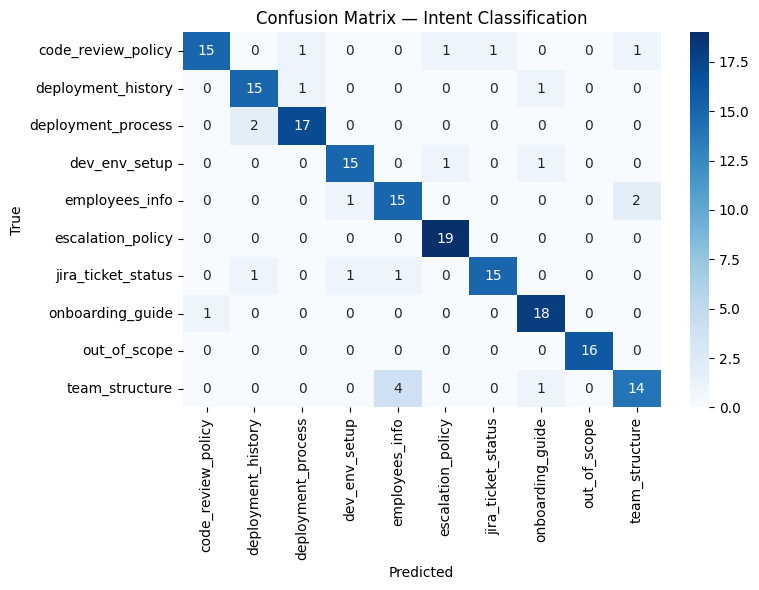

In [20]:
labels = np.unique(y_test)
cm = confusion_matrix(y_test, y_pred, labels=labels)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix — Intent Classification")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.tight_layout(); plt.show()


In [9]:
os.makedirs("../models", exist_ok=True)
model_path = "../ml/models/intent_pipeline.joblib"
joblib.dump(pipeline, model_path)
print("Saved:", model_path)


Saved: ../ml/models/intent_pipeline.joblib


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'clf__C': [0.01, 0.1, 1, 5, 10],
    'clf__penalty': ['l2'],
    'clf__solver': ['lbfgs', 'saga'],
    'clf__max_iter': [500, 1000, 2000]
}

grid = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=2
)
grid.fit(X_train, y_train)

print("Best Params:", grid.best_params_)
print("Best CV Score:", grid.best_score_)
